In [13]:
import norse
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
d0 = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
d = []
for t in d0:
    d.append(t)
    for i in range(9):
        d.append(0)
d = torch.tensor(d).unsqueeze(1).float()
len(d)

1000

In [3]:
c = norse.torch.SequentialState(
    torch.nn.Linear(1, 1, bias=False),
    norse.torch.LIFBoxCell(
        p=norse.torch.LIFBoxParameters(
            tau_mem_inv=torch.tensor([400]),
            v_th=torch.tensor([0.1]),
        ),
        dt=0.0001,
    ),
)
c[0].weight.data.fill_(1)

tensor([[1.]])

In [26]:
vs = []
zs = []
s = None
for t in d:
    z, s = c(t, s)
    zs.append(z.detach().numpy())
    vs.append(s[1].v.detach().numpy())
zs = np.array(zs)
pd.DataFrame(np.concatenate([d, vs, zs], axis=1)).to_csv("lif_norse.csv", index=False, header=False)

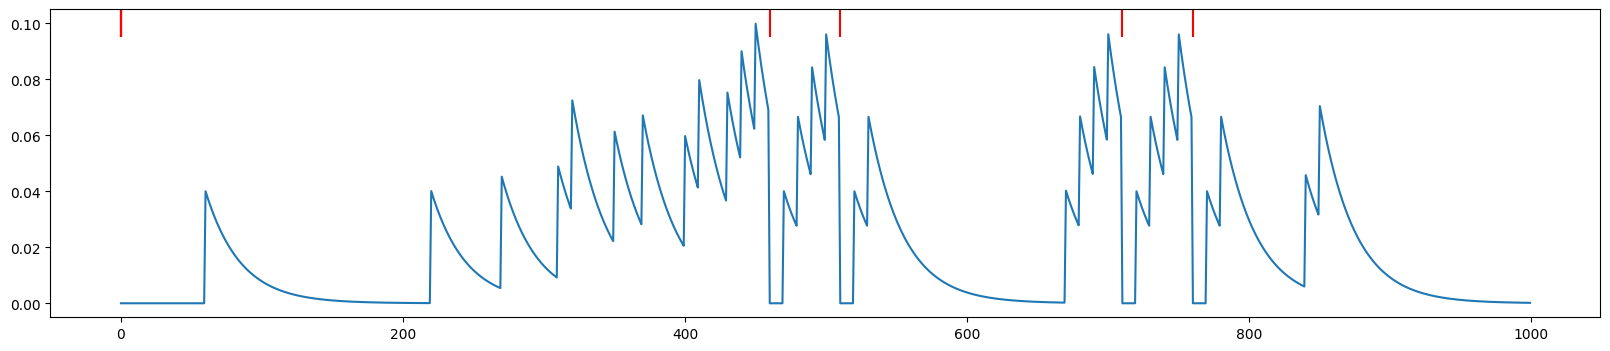

In [5]:
spikes = np.argwhere(zs > 0)
plt.figure(figsize=(20, 4))
plt.plot(vs)
plt.scatter(spikes, np.ones_like(spikes) * 0.1, marker="|", c="red", s=400)
zs = np.array(zs)
zs[zs > 0]
plt.savefig("lif_trace_norse.png")

In [6]:
nir_graph = norse.torch.to_nir(c, torch.tensor(d[0]), "lif")
nir_graph.nodes["1"].r = torch.tensor([1.0])      # Ensure arrays in Norse
nir_graph.nodes["1"].v_leak = torch.tensor([0.0]) # Ensure arrays in Norse
nir_graph

/tmp/ipykernel_1228602/3595732063.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nir_graph = norse.torch.to_nir(c, torch.tensor(d[0]), "lif")


NIRGraph(nodes={'input': Input(shape=array([1])), '0': Affine(weight=tensor([[1.]]), bias=tensor([0.])), '1': LIF(tau=tensor([0.0025]), r=tensor([1.]), v_leak=tensor([0.]), v_threshold=tensor([0.1000])), 'output': Output(shape=torch.Size([1]))}, edges=[('input', '0'), ('0', '1'), ('1', 'output')])

In [7]:
import nir
import importlib
importlib.reload(nir)

<module 'nir' from '/home/jens/work/nir/nir/nir/__init__.py'>

In [8]:
nir_graph

NIRGraph(nodes={'input': Input(shape=array([1])), '0': Affine(weight=tensor([[1.]]), bias=tensor([0.])), '1': LIF(tau=tensor([0.0025]), r=tensor([1.]), v_leak=tensor([0.]), v_threshold=tensor([0.1000])), 'output': Output(shape=torch.Size([1]))}, edges=[('input', '0'), ('0', '1'), ('1', 'output')])

In [9]:
nir.write("lif_norse.nir", nir_graph)

In [10]:
nir.read("lif_norse.nir")

NIRGraph(nodes={'0': Affine(weight=array([[1.]], dtype=float32), bias=array([0.], dtype=float32)), '1': LIF(tau=array([0.0025], dtype=float32), r=array([1.], dtype=float32), v_leak=array([0.], dtype=float32), v_threshold=array([0.1], dtype=float32)), 'input': Input(shape=array([1])), 'output': Output(shape=array([1]))}, edges=array([['input', '0'],
       ['0', '1'],
       ['1', 'output']], dtype=object))